# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
В нашем распоряжении набор фотографий с указанием возрастов покупателей. На основе этих данных необходимо построить модель, чтобы реализовать поставленную компанией задачу.
Ход работы:
- Проанализируем фотографии, посмотрим на них
- Построим модель, предсказывающюю возраст
- сделаем вывод по полученным результатам

Автор: Вересов Павел 
https://github.com/veresovpavel


## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels['real_age'].head(5)

0     4
1    18
2    80
3    50
4    17
Name: real_age, dtype: int64

Text(0.5, 1.0, 'Распределение возраста покупателей')

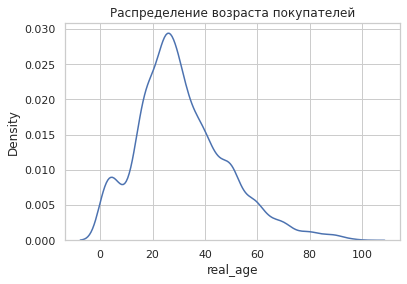

In [5]:
sns.set_theme(style="whitegrid")
sns.kdeplot(data=labels['real_age'])
plt.title('Распределение возраста покупателей')

Text(0.5, 1.0, 'Распределение возраста покупателей')

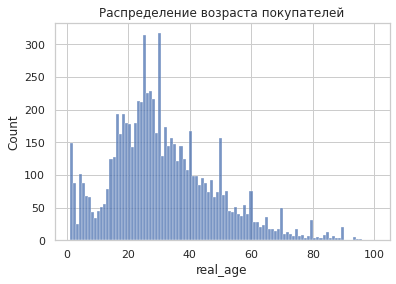

In [7]:
sns.set_theme(style="whitegrid")
sns.histplot(data=labels['real_age'], bins=100)
plt.title('Распределение возраста покупателей')

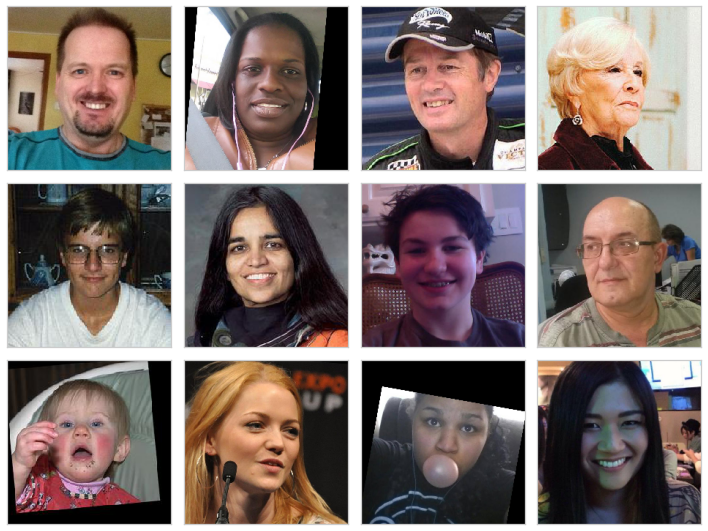

In [8]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В выборке 7591 фотография пользователей, что является не очень большим набором данных. Также часть фотографий повернута, на некоторых есть лишние объекты, где-то не видно часть лица, не все фото сделаны четко в профиль. Соответственно, это все надо учитывать при построении модели. Большинство фотографий принадлежат людям в возрасте 20-40 лет. Также видим явные пики на гистограмме с возрастами, кратными 10, что говорит о вероятном определении некоторых возрастов "на глаз".

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, AveragePooling2D,
                                     BatchNormalization, GlobalAveragePooling2D)
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25,
                                 horizontal_flip=True,
                                 rotation_range=45,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 zoom_range=0.1)


    train_data = datagen.flow_from_dataframe(
        labels, path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=1,
    )
    return train_data


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    test_data = datagen.flow_from_dataframe(
        labels, path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=1,
    )

    return test_data


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None,
                epochs=15, steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/15
2025-07-01 17:06:49.374446: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-07-01 17:06:49.763689: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 100s - loss: 266.4602 - mae: 11.8633 - val_loss: 838.7214 - val_mae: 24.1306
Epoch 2/15
178/178 - 93s - loss: 113.3800 - mae: 8.0860 - val_loss: 434.0480 - val_mae: 15.8437
Epoch 3/15
178/178 - 92s - loss: 90.4241 - mae: 7.2588 - val_loss: 184.0378 - val_mae: 10.1286
Epoch 4/15
178/178 - 93s - loss: 82.9636 - mae: 6.8806 - val_loss: 122.9433 - val_mae: 8.3397
Epoch 5/15
178/178 - 99s - loss: 72.9878 - mae: 6.5438 - val_loss: 96.8149 - val_mae: 7.3185
Epoch 6/15
178/178 - 94s - loss: 62.4185 - mae: 6.0546 - val_loss: 77.3262 - val_mae: 6.4630
Epoch 7/15
178/178 - 93s - loss: 57.4225 - mae: 5.8050 - val_loss: 71.8882 - val_mae: 6.2807
Epoch 8/15
178/178 - 94s - loss: 50.9829 - mae: 5.4916 - val_loss: 75.7588 - val_mae: 6.4457
Epoch 9/15
178/178 - 96s - loss: 46.2723 - mae: 5.1824 - val_loss: 104.8071 - val_mae: 7.9091
Epoch 10/15
178/178 - 95s - loss: 44.8573 - mae: 5.1458 - val_loss: 82.2172 - val_mae: 6.6282
Epoch 11/15
178/178 - 94s - loss: 39.6797 - mae: 4.8677 - val_loss: 78.2434 - val_mae: 6.4956
Epoch 12/15
178/178 - 94s - loss: 38.2969 - mae: 4.7412 - val_loss: 72.9445 - val_mae: 6.2605
Epoch 13/15
178/178 - 94s - loss: 34.4349 - mae: 4.5199 - val_loss: 89.1790 - val_mae: 6.8084
Epoch 14/15
178/178 - 93s - loss: 29.5950 - mae: 4.1871 - val_loss: 72.5609 - val_mae: 6.2681
Epoch 15/15
178/178 - 93s - loss: 28.3833 - mae: 4.1100 - val_loss: 70.6736 - val_mae: 6.2882
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 70.6736 - mae: 6.2882
```

## Анализ обученной модели

В результате построения модели на 15 эпохах была искомая метрика модели (mae) составила 6.3. Это меньше, чем описано в статье по исследованию данных фотографий (5.4), но также меньше критерия, предъявленного в задании (8). Эта ошибка модели при определении возраста, на мой взгляд, не совсем корректная метрика, так при возрасте 5-10 лет ошибка в 5 лет очень существенна, а 80-85 лет практически не имеет значения. Для обучения модели использовалась модель ResNet50 с заморозкой слоев, алгоритм Adam для оптимизации подбора параметров. По эпохам видно, что иногда ошибка увеличивалась, что может быть связано с переобучением, поэтому возможно стоило понизить параметр скорости обучения алгоритма, но это также мог бы и быть какой-либо локальный минимум функции. Также при загрузке данных использовался поворот фотографий, изменение ширины, длины, зума, что улучшало модель. Для улучшение работы модели можно было также сделать другую, которая выделяла бы лицо на фотографии и приводила его в стандартное положение, что в конечном итоге должно было бы улучшить результат модели.